<img src='./img/logo_fire_workshop.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="./33_geff_custom_danger_classes.ipynb"><< 33 - GEFF Custom Danger Classes </a><span style=float:right;><a href="./51_sentinel3_frp.ipynb">51 - Sentinel-3 Fire Radiative Power >></a></span>

# LSA SAF data products for fire monitoring

The [LSA SAF](https://landsaf.ipma.pt/en/) is the Satellite Aplication Facility on Land Surface Analysis, which is part of the distributed EUMETSAT Application Ground Segment. It is focused on the development and processing of satellite products that characterize the continental surfaces, such as `radiation products`, `vegetation`, `evapotranspiration` and `wild fires`. 

You can see [here](https://landsaf.ipma.pt/en/about/catalogue/) an overview of all LSA SAF data products offered.
LSA SAF data products are available as `near-real time (NRT)` and `data records`. The LSA SAF `data records` are gridded Level 3 data for the period 2004-2015.



#### This module has the following outline:
* [1 - Load, browse and visualize LSA SAF NRT EPS 10-days Fraction of Absorbed Photosynthetic Active Radiation (ETfAPAR)](#fapar)
* [2 - Load, browse and visualize LSA SAF EPS Daily Land Surface Temperature (EDLST)](#lst)
* [3 - Load, browse and visualize LSA SAF Fire Radiative Power Pixel (FRP Pixel)](#frp)
* [4 - Load, browse and visualize LSA SAF Normalized Difference Vegetation Index (NDVI)](#ndvi)

#### Load required libraries

In [2]:
import os
from netCDF4 import Dataset
import xarray as xr
import datetime
import h5py
import numpy as np

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

from IPython.display import display, clear_output

In [3]:
from ipynb.fs.full.functions import visualize_imshow

<hr>

## <a id="fapar"></a>Load, browse and visualize LSA SAF NRT EPS 10-days Fraction of Absorbed Photosynthetic Active Radiation (ETfAPAR)

The global LSA SAF FAPAR product is currently generated on a 10-days basis at the spatial resolution from the Advanced Very High Resolution Radiometer (AVHRR) sensor onboard the MetOp (Meteorological–Operational) satellite constellation also known as EUMETSAT Polar System (EPS).

The timeslot in the filename of this product corresponds to the last day of the 20-day time-compositing period. For example, the filename HDF5_LSASAF_M01-AVHR_ETFAPAR_GLOBE_201611250000 with day of production 25th November corresponds to the period November 6th-25th, 2016.

The data is disseminated in the `HDF5` format. You can load the `HDF5` data files with Python's [h5py](https://www.h5py.org/) library.

### Load HDF5 data with the `h5py` library

You can load a `HDF5` file with the `File` constructor of the `h5py` library. Load the file in `r` (read) mode.

The resulting object is a `HDF5 file` object, which acts like an iterator. Thus, with the `items` function you can list the different variables the file contains.

In [4]:
file_name = './eodata/lsa_saf/siberia/HDF5_LSASAF_M01-AVHR_ETFAPAR_SIBERIA_201907150000.HDF5'
file = h5py.File(file_name,'r')

for item in file.items():
    print(item)

('FAPAR', <HDF5 dataset "FAPAR": shape (4501, 10608), type "<i2">)
('FAPAR QF', <HDF5 dataset "FAPAR QF": shape (4501, 10608), type "|i1">)
('FAPAR err', <HDF5 dataset "FAPAR err": shape (4501, 10608), type "<i2">)
('LAT', <HDF5 dataset "LAT": shape (4501, 10608), type "<i2">)
('LON', <HDF5 dataset "LON": shape (4501, 10608), type "<i2">)
('Z_Age', <HDF5 dataset "Z_Age": shape (4501, 10608), type "|i1">)


Above, you see, that the file contains six different HDF5 datasets: `FAPAR`, `FAPAR QF`, `FAPAR err`, `LAT`, `LON` and `Z_Age`.

The `get` function allows you to select a dataset you are interested in. Let us select `FAPAR`:

In [5]:
fapar = file.get('FAPAR')
fapar

<HDF5 dataset "FAPAR": shape (4501, 10608), type "<i2">

With `[()]`, you can select the data values of the data set. The function `attrs.items()` lists the dataset's attributes:

In [6]:
fapar_vals = fapar[()]
fapar_vals

array([[ -10,  -10,  -10, ...,  -10,  -10,  -10],
       [ -10,  -10,  -10, ...,  -10,  -10,  -10],
       [ -10,  -10,  -10, ...,  -10,  -10,  -10],
       ...,
       [6429, 6732, 6491, ...,  -10,  -10,  -10],
       [6587, 6870, 6996, ...,  -10,  -10,  -10],
       [7494, 7405, 7097, ...,  -10,  -10,  -10]], dtype=int16)

In [7]:
for item in fapar.attrs.items():
    print(item)

('CAL_OFFSET', 0.0)
('CAL_SLOPE', 0.0)
('CLASS', b'Data')
('MISSING_VALUE', -10)
('NB_BYTES', 2)
('N_COLS', 10608)
('N_LINES', 4501)
('OFFSET', 0.0)
('PRODUCT', b'product')
('PRODUCT_ID', 0)
('SCALING_FACTOR', 0.0)
('UNITS', b'N/A')


### Mask the data

Let us store the `MISSING_VALUE` attribute value and define additionally a scaling factor. Both values are used to create a masked data array, where missing values are flagged out. With numpy's `ma.masked_values()` function, you can create a masked data array. The scaling factor scales the data into a range of [0,1].

In [8]:
missing_value = fapar.attrs['MISSING_VALUE']
missing_value

scaling_factor=10000.

In [9]:
fapar_masked = np.ma.masked_values(fapar, missing_value)
fapar_masked = fapar_masked / scaling_factor
fapar_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.6429, 0.6732, 0.6491, ..., --, --, --],
        [0.6587, 0.687, 0.6996, ..., --, --, --],
        [0.7494, 0.7405, 0.7097, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=-10)

### Visualize `LSA SAF ETfAPAR` data with matplotlib's `imshow()` function 

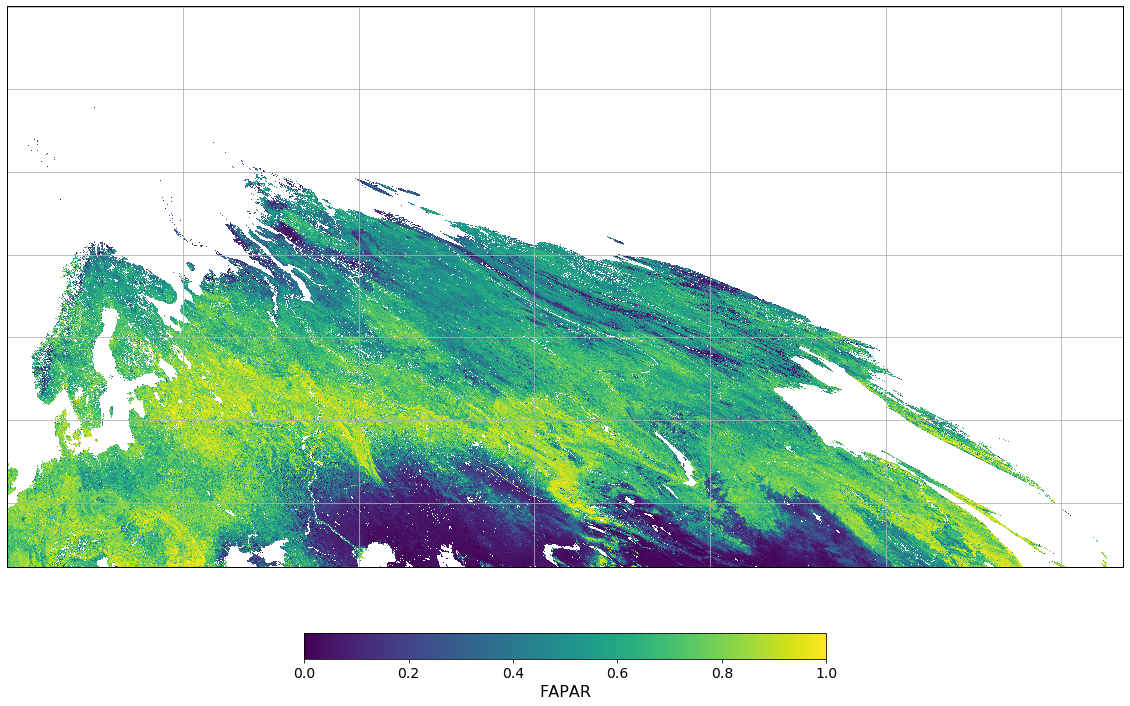

In [10]:
import cartopy.feature as cfeature
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()

img1 = plt.imshow(fapar_masked,
                          cmap='viridis',
                          vmin=0,
                          vmax=1,
                          aspect='auto')

cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('FAPAR',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

<br>

## <a id='lst'></a>Load, browse and visualize LSA SAF EPS Daily Land Surface Temperature data (ELDST)

The [EDLST (EPS Daily Land Surface Temperature)](https://landsaf.ipma.pt/en/products/land-surface-temperature/edlst/) provides day- and night-time retrievals of LST based on clear-sky measurements from the Advanced Very High Resolution Radiometer (AVHRR) on-board EUMETSAT polar system satellites, the Metop series.

In [11]:
file = h5py.File('./eodata/lsa_saf/sweden/HDF5_LSASAF_M01-AVHR_EDLST-DAY_Sweeden_201807160000', 'r')
file

for item in file.items():
    print(item)

('LAT', <HDF5 dataset "LAT": shape (1501, 1093), type "<i2">)
('LON', <HDF5 dataset "LON": shape (1501, 1093), type "<i2">)
('LST-day', <HDF5 dataset "LST-day": shape (1501, 1093), type "<i2">)
('QFLAG-day', <HDF5 dataset "QFLAG-day": shape (1501, 1093), type "|i1">)
('VZA-day', <HDF5 dataset "VZA-day": shape (1501, 1093), type "|i1">)
('aquisition_time-day', <HDF5 dataset "aquisition_time-day": shape (1501, 1093), type "<i2">)
('n-day', <HDF5 dataset "n-day": shape (1501, 1093), type "|i1">)


Above, you see, that the file contains seven different HDF5 datasets: `LAT`, `LON`, `LST-day`, `QFLAG-day`, `VZA-day`, `aquisition` and `n-day`.

The `get` function allows you to select a dataset you are interested in. Let us select `LST-day`, which is the Land Surface Temperature during the day:

In [12]:
lst_day = file.get('LST-day')
lst_day


<HDF5 dataset "LST-day": shape (1501, 1093), type "<i2">

With `[()]`, you can select the data values of the data set. The function `attrs.items()` lists the dataset's attributes:

In [13]:
lst_day[()]

array([[-29999, -29999, -29999, ..., -29999, -29999, -29999],
       [-29999, -29999, -29999, ..., -29999, -29999, -29999],
       [-29999, -29999, -29999, ..., -29999, -29999, -29999],
       ...,
       [-29999, -29999, -29999, ..., -29999, -29999, -29999],
       [-29999, -29999, -29999, ..., -29999, -29999, -29999],
       [-29999, -29999, -29999, ..., -29999, -29999, -29999]], dtype=int16)

In [14]:
for item in lst_day.attrs.items():
    print (item)

('CAL_OFFSET', 0.0)
('CAL_SLOPE', 999.0)
('CLASS', b'Data')
('MISSING_VALUE', -29999)
('NB_BYTES', 2)
('N_COLS', 1093)
('N_LINES', 1501)
('OFFSET', 0.0)
('PRODUCT', b'LST-day')
('PRODUCT_ID', 0)
('SCALING_FACTOR', 100.0)
('UNITS', b'degrees (C)')


### Mask the LSA SAF LST data

Let us store the `MISSING_VALUE` and `SCALING_FACTOR` attribute values . Both values are used to create a masked data array, where missing values are flagged out. With numpy's `ma.masked_values()` function, you can create a masked data array. The scaling factor scales the data into a range of [0,1].

In [15]:
missing_value = lst_day.attrs['MISSING_VALUE']
scaling_factor = lst_day.attrs['SCALING_FACTOR']
missing_value, scaling_factor

(-29999, 100.0)

In [16]:
lst_day_masked = np.ma.masked_values(lst_day, missing_value)
lst_day_masked = lst_day_masked / scaling_factor
lst_day_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-29999)

### Visualize `LSA SAF ELDST` data with matplotlib's `imshow()` function 

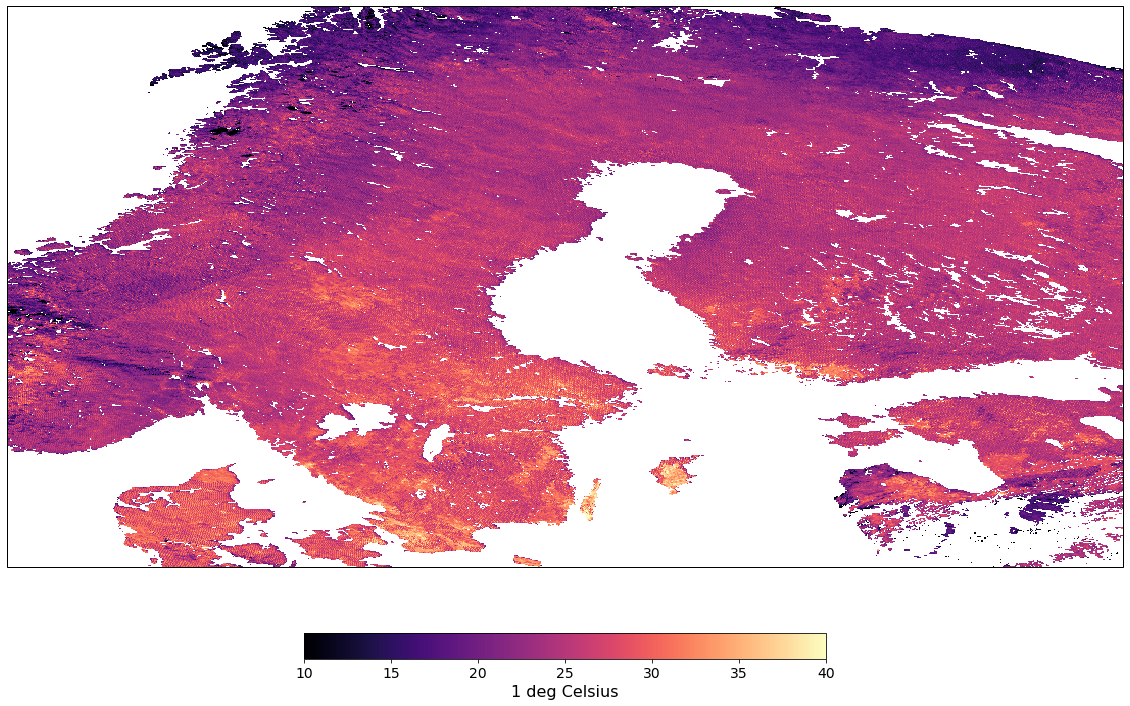

In [17]:
visualize_imshow(lst_day_masked, 
                 projection=ccrs.Sinusoidal(), 
                 conversion_factor=1, 
                 color_scale='magma', 
                 vmin=10, vmax=40, 
                 lonmin=-180, 
                 lonmax=180, 
                 latmin=-90, 
                 latmax=90, 
                 unit='deg Celsius', 
                 set_global=False, 
                 log_scale=False)






<br>

## <a id='frp'></a>Load, browse and visualize LSA SAF Fire Radiative Power Pixel (FRP Pixel)

The [FRPPIXEL product](https://landsaf.ipma.pt/en/products/fire-products/frppixel/) records information on the location, timing and fire radiative power (FRP, in MWatts) output of landscape fires ("wildfires") at the native spatial resolution of the SEVIRI sensor. 

Measuring FRP and integrating it over the lifetime of a fire provides an estimate of the total Fire Radiative Energy (FRE) released, which for landscape fires should be proportional to the total amount of biomass burned.

The disseminated product includes two HDF5 format files:
- `Quality Product file`: stores information for each SEVIRI pixel of why it was or was not detected as an active fire pixel
- `List Product file`: for all confirmed active fire pixels stores the location and time of the detection together with the fire pixels atmospherically corrected FRP and uncertainty (MW), the fire detection confidence measure (representing the level of confidence that the observation is indeed a "true" fire), and various other metrics including the individual spectral channel input signals.



### Load and browse the `List Product` file

The `List Product` file is disseminated in `HDF5` format. You can use the `h5py` library and it's `File` function to read the file.

The resulting object is a `HDF5 file` object, which acts like an iterator. Thus, with the `items` function you can list the different variables the file contains

In [ ]:
file = h5py.File('./eodata/lsa_saf/sweden/HDF5_LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_201807161745', 'r')

for item in file.items():
    print(item)

Above, you see, that the file contains a range of different parameters. 

The `get` function allows you to select a dataset you are interested in. Let us select `FRP`, which is the `Fire Radiative Power`:

In [ ]:
frp = file.get('FRP')
frp


With `[()]`, you can select the data values of the data set. The function `attrs.items()` lists the dataset's attributes:

In [ ]:
for item in frp.attrs.items():
    print(item)

### Mask the Fire Radiative Power Pixel (FRP Pixel) values

Let us store the `MISSING_VALUE` and `SCALING_FACTOR` attribute values. Both values are used to create a masked data array, where missing values are flagged out. With numpy's `ma.masked_values()` function, you can create a masked data array.

In [ ]:
scaling_factor = frp.attrs['SCALING_FACTOR']
missing_value = frp.attrs['MISSING_VALUE']

frp_masked = np.ma.masked_values(frp[()], missing_value)
frp_masked = frp_masked / scaling_factor
frp_masked

### Load and mask `latitude` values

Repeat the masking for `latitude` values.

In [ ]:
lat = file.get('LATITUDE')
lat

scaling_factor = lat.attrs['SCALING_FACTOR']
missing_value = lat.attrs['MISSING_VALUE']

lat_masked = np.ma.masked_values(lat[()], missing_value)
lat_masked = lat_masked / scaling_factor
lat_masked

### Load and mask `longitude` values

Repeat the masking for `longitude` values.

In [ ]:
lon = file.get('LONGITUDE')
lon

scaling_factor = lon.attrs['SCALING_FACTOR']
missing_value = lon.attrs['MISSING_VALUE']

lon_masked = np.ma.masked_values(lon[()], missing_value)
lon_masked = lon_masked / scaling_factor
lon_masked

### Visualize `FRP Pixel` values with matplotlib's `scatter` function

You can created a customized `ColorMap` and define the levels for the respective `FRP` classes.

In [ ]:
frp_cm = ListedColormap([[0, 0, 255./255.],
                                 [176./255., 196./255., 222./255.],
                                 [255./255., 255./255., 0],
                                 [1., 140./255., 0],
                                 [178./255., 34./255., 34./255.],
                                 [1, 0, 0]])
bounds = [0, 30, 40, 60, 80, 120, 500]
norm = BoundaryNorm(bounds, frp_cm.N)


The last step is to visualize the `FRP` data with matplotlib's `scatter` function. You use the masked data information of `latitude`, `longitude` and `frp`.

In [ ]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, zorder=3)
gl = ax.gridlines()
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}


img1 = plt.scatter(lon_masked,lat_masked, c=frp_masked,
                   edgecolors='none',
                   cmap=frp_cm,
                   norm=norm,
                   zorder=2)


cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label('MW',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

<br>

## <a id='ndvi'></a>Load, browse and visualize LSA SAF `Normalized Difference Vegetation Index (NDVI)`

The [LSA SAF Normalized Difference Vegetation Index (NDVI)](https://landsaf.ipma.pt/en/products/vegetation/endvi/) are near-global, 10-daily composite images which are synthesized from the "best available" observations registered in the course of every "dekad" by the orbiting earth observation system MetOp-AVHRR. The composites represent a `Normalized Difference Vegetation Index` and are distributed together with a set of ancillary dataset layers (surface reflectances, sun and view angles, quality indicators) as part of EUMETSAT LSA SAF program.

From a temporal aspect, every month is divided in three "dekads". The first two always comprise ten days (1-10, 11-20), the third one has variable length as it runs from day 21 until the end of the month. The distinction between "days" is based on UT/GMT criteria.

From a spectral aspect, each composite comprises twelve separate image layers. The NDV layer represents the Normalized Difference Vegetation Index, while the other layers are considered as ancillary layers: synthesis reflectance values, viewing angles, status map.

The composites are transferred to the users in ZIP-form. Each ZIP thus comprises 26 files: twelve IMGs, twelve HDRs, one XML (INSPIRE compatible metadata) and one TIFF (a quicklook map of the NDVI layer).

In [ ]:
file = './eodata/lsa_saf/siberia/METOP_AVHRR_20190721_S10_ASn_NDV.img'


Let us store the metadata information of the `HDR` files as dictionary. This can be done with the following for loop:

In [ ]:
hdr = os.path.splitext(file)[0]+'.hdr'
hdr
hdr_set = {}

myfileobj = open(hdr, "r")    
for line in myfileobj.readlines():   
    line = [x.strip() for x in line.split(' = ')]
    if len(line) > 1:
        if line[0] == 'values':
            line[0] = 'VALUES'
        hdr_set[line[0]] = line[1]

hdr_set

#### Helper function `hdrtypelib` to retrieve `envidtype`

In [ ]:
def hdrdtypelib():
    """
    Derived from Gaston library (Roel).
    Translates BPP (Bytes Per Pixel) to dtype string.
    """
    envidtypelib = {'1':'uint8',
                  '2':'int16',
                  '3':'int32',
                  '4':'float32'}
    return envidtypelib

Retrieve the `datatype` from the `hdr` dictionary and load the respective `envidtype` with the help of the `hdrtypelib()` function. The `datatype` of this example is `1`, which translates to `uint8`.

In [ ]:
hdrdtype =  hdr_set['data type'] #get datatype from hdr_set
envidtypelib = hdrdtypelib()
dtype = envidtypelib[hdrdtype]

Load the DN values from the image file as `numpy array` with numpy's function `np.fromfile()`. Once the data is loaded, you want to convert it into a `2D-array`.

In [ ]:
#get DN from image
data=np.fromfile(file,dtype=dtype)
#convert to 2D array
data.shape=(-1,int(hdr_set['samples']))
data

#Convert to float64 datatype
data_2 = np.float64(data)
data_2

### Mask the data with numpy's `np.ma.masked_values` function

Mask the data with numpy's function `np.ma.masked_values()`. Missing value is the data array's maximum values.

In [ ]:
missing_value = np.max(data_2)
data_masked = np.ma.masked_values(data_2, missing_value)
data_masked_4 = 0.004*data_masked-0.08
data_masked_4

### Visualize the `NDVI` values with matplotlib's `imshow` function

Now, you can plot the data array with the `imshow` function of the matplotlib library.

In [ ]:
fig=plt.figure(figsize=(20, 12))

ax=plt.axes(projection=ccrs.Sinusoidal())
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
gl = ax.gridlines()


img1 = plt.imshow(data_masked_4,
                          vmin=0,
                          vmax=1,
                          aspect='auto')


cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(' ',fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

<a href="./33_geff_custom_danger_classes.ipynb"><< 33 - GEFF Custom Danger Classes </a><span style=float:right;><a href="./51_sentinel3_frp.ipynb">51 - Sentinel-3 Fire Radiative Power >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.